In [1]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox




list_of_period = [5,10,15,20,25,30]
list_of_k = [1,1.5,2]
period = 20
k = 2

# Read the data from the Excel file
xls_file = '/home/vishi/bolinger/cumul_ohlc.xls'
xls = xlrd.open_workbook(xls_file)
sheet = xls.sheet_by_index(0)
# Extract the data
closing_prices = []
for row in range(1, sheet.nrows):
    closing_prices.append(sheet.cell_value(row, 4))

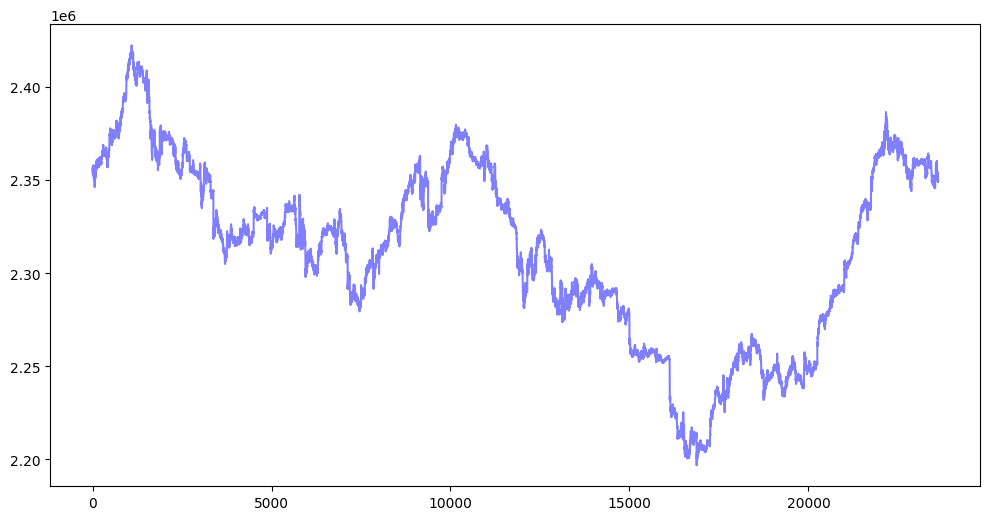

In [2]:
# plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(closing_prices, label='Closing Prices', color='blue', alpha=0.5)
plt.show()

In [3]:
# test ADF for closing prices
res_cloing_prices = adfuller(closing_prices)
print('ADF Statistic for closing prices: %f' % res_cloing_prices[0])
print('p-value for closing prices: %f' % res_cloing_prices[1])


ADF Statistic for closing prices: -1.390804
p-value for closing prices: 0.586677


In [4]:
diff_closing_prices = np.diff(closing_prices)
result = adfuller(diff_closing_prices)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -29.04806007292808
p-value: 0.0


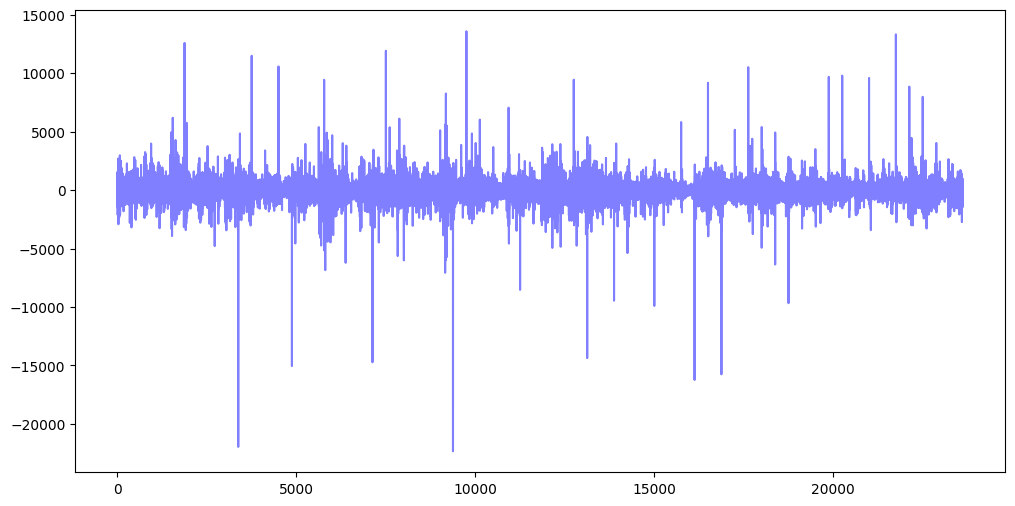

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(diff_closing_prices, label='Diff Closing Prices', color='blue', alpha=0.5)
plt.show()

In [6]:
diff_series = pd.Series(diff_closing_prices)

# Ljung–Box test (check up to lag 10)
ljung_box_results = acorr_ljungbox(diff_series, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat     lb_pvalue
10  83.123276  1.222797e-13


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                23625
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -194056.421
Date:                Thu, 15 May 2025   AIC                         388118.842
Time:                        10:15:49   BIC                         388143.052
Sample:                             0   HQIC                        388126.699
                              - 23625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2939      0.475     -0.618      0.536      -1.226       0.638
ma.L1          0.2957      0.475      0.622      0.534      -0.636       1.227
sigma2      7.967e+05   1221.251    652.340      0.0

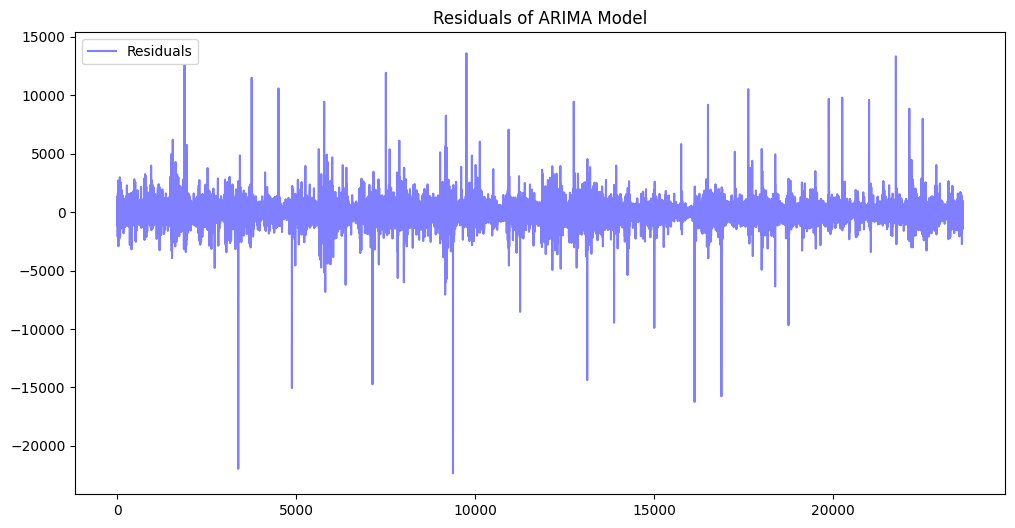

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(closing_prices, order=(1, 1, 1))  # example order
fitted_model = model.fit()
print(fitted_model.summary())
residuals = fitted_model.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals[1:], label='Residuals', color='blue', alpha=0.5)
plt.title('Residuals of ARIMA Model')
plt.legend()
plt.show()

In [8]:
from statsmodels.stats.diagnostic import het_arch

# Test if there's autoregressive conditional heteroskedasticity (ARCH effect)
arch_test = het_arch(residuals)
print(f'ARCH test p-value: {arch_test[1]}')  # p < 0.05 → GARCH justified


ARCH test p-value: 1.5778892114723144e-06


In [9]:
from arch import arch_model
scaled_residuals = 0.001 * residuals

# We'll fit GARCH(1,1) to the residuals (or to the differenced series directly)
garch_model = arch_model(scaled_residuals, vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit()
print(garch_fit.summary())
print(f"GARCH() - AIC/BIC: {garch_fit.aic/garch_fit.bic}")



Iteration:      1,   Func. Count:      6,   Neg. LLF: 11575574.680382518
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4545253188.3305235
Iteration:      3,   Func. Count:     20,   Neg. LLF: 222590.58223653436
Iteration:      4,   Func. Count:     26,   Neg. LLF: 49127.75839820244
Iteration:      5,   Func. Count:     31,   Neg. LLF: 53736931.48692404
Iteration:      6,   Func. Count:     41,   Neg. LLF: 67078926.600033715
Iteration:      7,   Func. Count:     47,   Neg. LLF: 472840.90354953933
Iteration:      8,   Func. Count:     53,   Neg. LLF: 85423.51324868208
Iteration:      9,   Func. Count:     59,   Neg. LLF: 4480426665.971372
Iteration:     10,   Func. Count:     65,   Neg. LLF: 161400908.2731728
Iteration:     11,   Func. Count:     74,   Neg. LLF: 14708902.095577445
Iteration:     12,   Func. Count:     80,   Neg. LLF: 3823860340.949318
Iteration:     13,   Func. Count:     86,   Neg. LLF: 1805719113734.174
Iteration:     14,   Func. Count:     94,   Neg. LLF: 3204

In [10]:

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# scale the residuals
for p in range(1, 3):
    for q in range(1, 3):
        model = arch_model(scaled_residuals, vol='GARCH', p=p, q=q)
        fit = model.fit(disp="off")
        print(f"GARCH({p},{q}) - AIC/BIC: {fit.aic/fit.bic}")


GARCH(1,1) - AIC/BIC: 0.9994592104184783
GARCH(1,2) - AIC/BIC: 0.9993241270451042
GARCH(2,1) - AIC/BIC: 0.9993240168846249
GARCH(2,2) - AIC/BIC: 0.9991890892343832


Processed 0 data points
Processed 100 data points
Processed 200 data points
Processed 300 data points
Processed 400 data points
Processed 500 data points
Processed 600 data points
Processed 700 data points
Processed 800 data points
Processed 900 data points


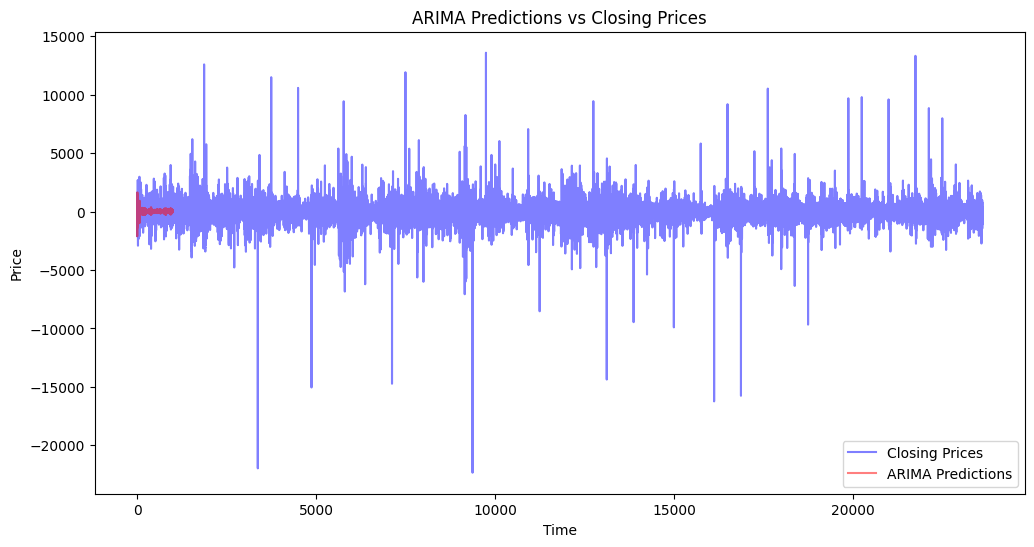

In [11]:
# a function that cauclulates the next prediction using ARIMA 
# we will use the idea of rolling origin i.e. use 1,...2,...,n-1 to predict n then use 1,...,n-1,n to predict n+1

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def arima_predict(data_partial, period, k,order_of_arima):
    # Fit the ARIMA model
    model = ARIMA(data_partial, order=order_of_arima)  # Change the order here
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)[0]
    return forecast

def get_arima_predictions(data,order_of_arima,threshold = 20):
    predictions = []
    for i in range(len(data)):
        if i <  threshold:
            predictions.append(data[i])
        else:
            data_partial = data[:i]
            prediction = arima_predict(data_partial, period, k,order_of_arima)
            predictions.append(prediction)
        if i % 100 == 0:
            print(f"Processed {i} data points")
    return predictions
# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(data, period, k):
    rolling_mean = pd.Series(data).rolling(window=period).mean()
    rolling_std = pd.Series(data).rolling(window=period).std()
    upper_band = rolling_mean + (k * rolling_std)
    lower_band = rolling_mean - (k * rolling_std)
    return upper_band, lower_band

prediction_of_arima = get_arima_predictions(diff_closing_prices[:1000],(2, 0, 2))

# plot the predictions and our data
plt.figure(figsize=(12, 6))
plt.plot(diff_closing_prices, label='Closing Prices', color='blue', alpha=0.5)
plt.plot(prediction_of_arima, label='ARIMA Predictions', color='red', alpha=0.5)
plt.title('ARIMA Predictions vs Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

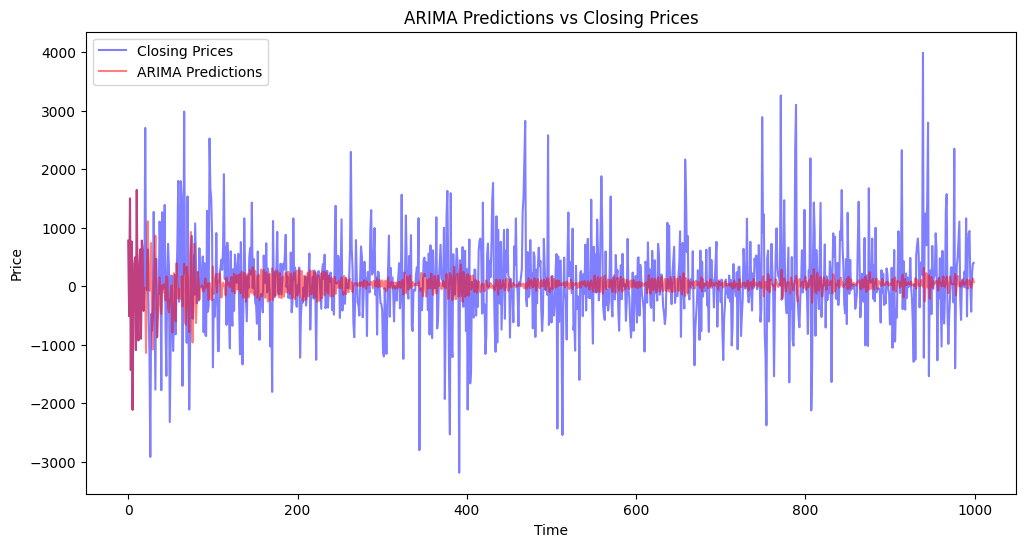

In [12]:
# plot the predictions and our data
plt.figure(figsize=(12, 6))
plt.plot(diff_closing_prices[:1000], label='Closing Prices', color='blue', alpha=0.5)
plt.plot(prediction_of_arima, label='ARIMA Predictions', color='red', alpha=0.5)
plt.title('ARIMA Predictions vs Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

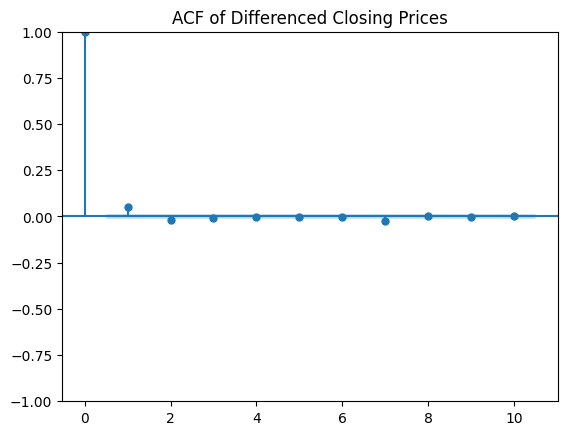

<Figure size 1200x600 with 0 Axes>

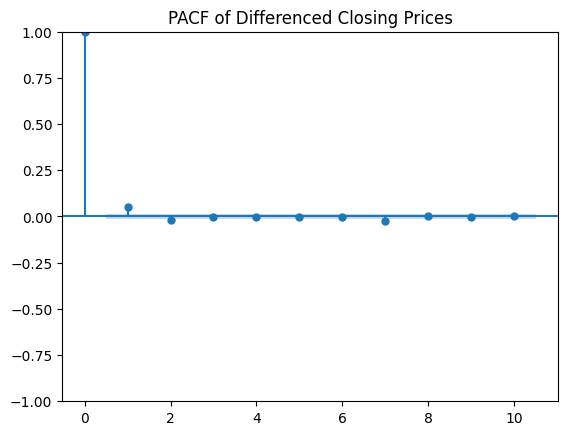

In [13]:

# Perform the Augmented Dickey-Fuller test

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(diff_closing_prices, lags=10)
plt.title('ACF of Differenced Closing Prices')
plt.show()
plt.figure(figsize=(12, 6))
plot_pacf(diff_closing_prices, lags=10)
plt.title('PACF of Differenced Closing Prices')
plt.show()

In [14]:
def get_arima_bands(prices, period=20, k=2):
    prices = np.array(prices)
    avg = np.zeros(len(prices))
    std = np.zeros(len(prices))

    for i in range(period, len(prices)):
        train_series = prices[i - period:i]
        
        try:
            model = ARIMA(train_series, order=(1, 1, 1))  # you can tune (p,d,q)
            fitted = model.fit()
            forecast_result = fitted.get_forecast(steps=1)
            avg[i] = forecast_result.predicted_mean[0]
            std[i] = np.sqrt(forecast_result.var_pred_mean[0])  # forecast variance -> std
        except Exception as e:
            print(f"ARIMA error at index {i}: {e}")
            avg[i] = np.nan
            std[i] = np.nan

    upper_band = avg + k * std
    lower_band = avg - k * std
    return avg, upper_band, lower_band
